In [49]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx 
from scipy.ndimage import gaussian_filter

from skimage.segmentation import watershed
from skimage.morphology import disk
from skimage import img_as_ubyte
from skimage.measure import label, regionprops, euler_number
from skimage.future.graph import RAG
from sknetwork.path import distance
from skimage import util
from skimage import filters

from tqdm import tqdm

from cvxopt import solvers, matrix, div, log, exp

In [2]:
#get image and define the image space
image = plt.imread('../images/dna-images/gnf/dna-0.png')[...,0]
image_range = np.array([[i,j]for i in range(image.shape[0]) for j in range(image.shape[1])])

## Algorithm I

In [3]:
def generate_fragments(img,std_dev,int_threshold,min_seed_dist,max_search_depth,max_frag_dist):
    img = img_as_ubyte(img)
    #smooth image with gausian filter
    g = gaussian_filter(img,std_dev)
    
    #Fehlerabfangen
    
    if std_dev < 0:
        raise ValueError("smoothing strength needs to be positive")
    if int_threshold > 1 or int_threshold < 0:
        raise ValueError("relative intensity threshold needs to be between 0 and 1")
    if min_seed_dist < 1:
        raise ValueError("min seed distance needs to be >= 1")
    if max_search_depth < 0:
        raise ValueError("maximum search error needs to be positive")
    if max_frag_dist < 0:
        raise ValueError("maximum fragments distance needs zo be positive")
        
    #Create array of watershed segmentation
    B = disk(min_seed_dist)
    P = (g==filters.rank.maximum(g,B)) & ((1-int_threshold)*g >= filters.rank.minimum(g,B))
    g_markers = label(P)

    #Create Watershed regions
    Omega = watershed(util.invert(g),markers=g_markers)
    G = RAG(Omega,connectivity=2)
    #create PI
    PI = regionprops(g_markers)

    #Remove edges if cdntroids are to far away
    for edge in tqdm(G.edges()):
        if np.linalg.norm(np.array(PI[edge[0]-1].centroid) - np.array(PI[edge[1]-1].centroid)) >= max_frag_dist:
            G.remove_edge(edge[0],edge[1])
    nx.draw(G, with_labels = True)


    S = set()
    #iterate over all conected components (cc)
    for nodes_in_cc in nx.algorithms.connectivity.edge_kcomponents.k_edge_subgraphs(G,1):
        H = G.subgraph(nodes_in_cc)
        for v in tqdm(nodes_in_cc):
            S.add(frozenset([v]))
            for distance in range(1,max_search_depth+1):
                distance_from_origin = nx.single_source_shortest_path_length(H, v,cutoff=distance)
                for node_amount in range(2,len(distance_from_origin.values())):
                    for node_subset in itertools.combinations(set([v]).union(set([node for node in distance_from_origin.keys()])), node_amount):
                        if frozenset(node_subset) not in S:
                            if nx.is_connected(H.subgraph(node_subset)):
                                #check that the merge of the regions is simply connected
                                sub_img = np.zeros(Omega.shape, dtype = bool)
                                for subregion in node_subset:
                                    img_label = Omega == subregion
                                    sub_img += img_label
                                if euler_number(sub_img) == 1:
                                     S.add(frozenset(node_subset))

    return Omega,S

###  Test: Algorithm I

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


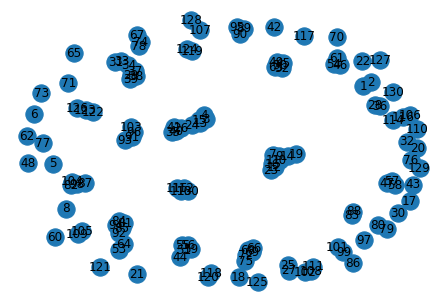

In [4]:
#testing Alg I
Omega,S = generate_fragments(image,16,0.01,20,2,100)

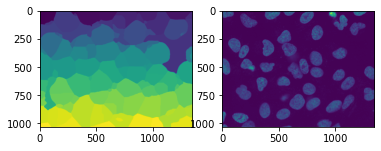

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(Omega)
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(image)

In [29]:
print(S)

{frozenset({4, 41, 15, 24, 26}), frozenset({86}), frozenset({91, 93}), frozenset({40, 24, 26, 13}), frozenset({98, 82}), frozenset({16, 11, 23, 7}), frozenset({89}), frozenset({74, 67}), frozenset({56, 59, 51, 44}), frozenset({40, 24, 26, 35}), frozenset({40, 26, 35}), frozenset({3, 4}), frozenset({33}), frozenset({3, 41, 13, 24, 26}), frozenset({16, 10, 14, 23}), frozenset({3, 35, 4, 41, 13, 15, 24, 26}), frozenset({7, 9, 10, 14, 19}), frozenset({4, 13, 15, 24, 26}), frozenset({7, 9, 10, 11, 12, 16, 23}), frozenset({35, 13, 15, 24, 26}), frozenset({49, 50, 52, 45}), frozenset({97}), frozenset({16, 10, 11}), frozenset({16, 9, 10, 11}), frozenset({49, 52, 45}), frozenset({98, 82, 87}), frozenset({9, 10, 11, 16, 23}), frozenset({104}), frozenset({52, 45}), frozenset({88}), frozenset({40, 41, 26, 35}), frozenset({128}), frozenset({3, 35, 4, 40, 41, 13, 24, 26}), frozenset({52, 63}), frozenset({9, 10, 11, 12, 14, 19, 23}), frozenset({61, 54}), frozenset({29, 38}), frozenset({66, 68}), froz

We check that the subimage created by the merge of the regions are simply connected. We did a random check for the subimage created by {40, 24, 26, 13} and the one created by {81, 84, 94}.

1

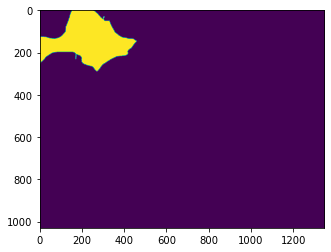

In [52]:
img_a = Omega == 40
img_b = Omega == 24
img_c = Omega == 26
img_d = Omega == 13

plt.imshow(img_a + img_b + img_c + img_d)
euler_number(img_a+img_b+img_c+img_d)

1

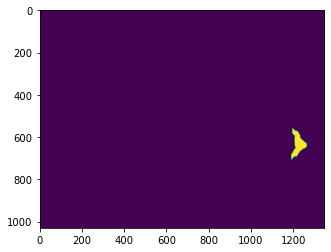

In [31]:
img_a = Omega == 81
img_b = Omega == 84
img_c = Omega == 94

plt.imshow(img_a + img_b + img_c)
euler_number(img_a + img_b + img_c)

### Algorithm II

In [115]:
def global_solution(f,alpha,Omega,S):
    #Set Variables we dont need Z but f_used
    n = len(S) 
    u = np.zeros(n)
    V = Omega
    f_used = np.copy(f)
    #First Loop over copy of Omega
    while V != 0:
        c = np.empty(n)
        #Loop over number of Subgraphs in S
        for k in range(n):
            #Set intersection length
            Zk_V = len(np.intersect1d(Omega,np.array(list(S[k]))))
            #Set c if intersection is non empty 
            if  Zk_V !=0:
                c[k] = (f[k] + alpha) / Zk_V
            #Else set it to nan to ignore it
            else:
                c[k] = np.nan
        #Get the argmin of c
        k_min = np.nanargmin(c)
        #Set u of argmin to 1
        u[k_min] = 1 
        #Loop over all areas in Z_k
        for w in S[k]:
            #Set V of those areas to 0 to indicate that they have been used already
            V[V==w] = 0
    
    #Second loop over not used elements of f
    while f_used != np.empty(n):
        #Set current element of interest k_prim
        k_prim = np.nanargmin(f_used)
        #check if u[_k_prim hasn been used in first loop
        if u[k_prim]==0:
            #crate subvector v of u
            v = np.copy(u)
            #loop over all elements of u that are non zero
            for ind in np.nonzero(u):
                #check if Z_ind is subset of Z_kprim
                if S[ind] not in S[k_prim]:
                    #if not set v to 0 to ignore it in the union
                    v[ind] = 0
            #check if union of all left subsets is equal Z_kprim
            if S[k_prim] == set().union(S[k] for k in np.nonzero(v)):
                #check smth...
                if f[k_prim]+alpha < np.dot(v,f + (alpha*np.ones(n))):
                    #Set u values of the used subsets to 0 and the union to 1
                    u = u-v
                    u[k_prim] = 1
        #make f equal to nan for the used region
        f_used[k_prim]=np.nan
    return u

In [38]:
#Computation of the intensity threshold
def Otsu_thresholding(Z):
    #Set Number of bins 256 for 8-bit
    L = 256
    #Set number of pixel in area Z
    N = Z.size
    #Get the grayvalue histogramm
    hist, _ = np.histogram(Z,bins=L)
    #normalize to get probability distribution
    hist = hist/N
    #function with all variables needed to compute sigma^2_B corresponding to the k-th bin
    def get_sigma(k):
        w = sum(hist[:k+1])
        w_0 = w
        w_1 = 1 - w
        #ignore certain bins according to restricten
        if w_0*w_1 > 0 or 0 < w_0 < 1:
            my = lambda k: sum(i*hist[i] for i in range(k+1))
            my_0 = my(k)/w
            my_1 = (my(L-1)-my(k))/w_1
            sigma_B = w_0*w_1*(my_1-my_0)**2
            return sigma_B
        else:
            return 0
    #compute sigma for all k
    sigma_B_all = np.array([get_sigma(k) for k in range(L)])
    #get the bin with wich maximizes sigma 
    k_max = np.argmax(sigma_B_all)
    #rescale the bin number to the value range of the local area to optain intensity threshold
    tau = k_max*np.max(Z)/(256)
    return tau

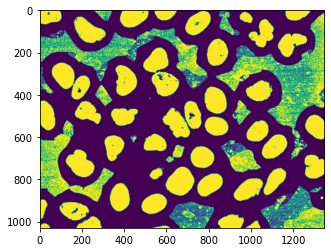

In [39]:
#Test Otsu threshold
#Set label vector
labels = np.unique(Omega)
#Set Vector of local intensity threshold tau coresponding to area with label 
tau = [Otsu_thresholding(image[Omega==label])for label in labels]
#copy image to check threshold
background = np.copy(image)
#loop over all labeled regions and apply threshold
for i in range(len(tau)):
    background[Omega==i+1] -= tau[i]
background[background<0]=0
background[background>0]=1
plt.imshow(background)
plt.show()

#TODO Compute f --> get alpha as median of f

## Computation of f

We use a second-order solver for non-linear unconstrained convex problem. To do so, we define $\theta^T = [a_1, a_2, a_3, b_1, b_2, c]$ and as such define for a pixel $x \in R$ (R = region.coords) $\subset \mathbb{R}^2$ 
$$\begin{align*}
s(x, \theta) &= x^T \begin{pmatrix} a_1 & a_3 \\ a_3 & a_2 \end{pmatrix} x + \begin{pmatrix} b_1, b_2 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} + c \\
&= x^T \begin{pmatrix} \theta[0] & \theta[2] \\ \theta[2] & \theta[1] \end{pmatrix} x + \begin{pmatrix} \theta[3], \theta[4] \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} + \theta[5] \\
&= a_1 x_1^2 + a_2x_2^2 + 2a_3x_1x_2 + b_1x_1 + b_2x_2 + c \\
&= \nabla s(x)^T * \theta 
\end{align*}$$
for $\nabla s(x)^T = [x_1^2, x_2^2, 2x_1x_2, x_1, x_2, 1]$

In [88]:
def J_energy(image, region, tau):
    #define y_x for every element in the region
    y = image[region.slice] - tau
    #define nable s(x) for each element
    delta_s = [[x[0]**2, x[1]**2, 2*x[0]*x[1], x[0], x[1], 1] for x in region.coords]
    def F(theta):
        # s contains region.area many rows, each row contains a scalar.
        s = delta_s * theta
        #TODO: assert len(s) = len(phi) = region.area
        phi = [log(1+exp(-y[i] * s[i])) for i in range(region.area)]
        J = sum(phi)
        k = phi**-1
        DJ = sum(-y*k*delta_s).T
        H = sum(y**2 * (kappa - kappa**2)*delta_s * delta_s.T)
        return J, DJ, H
    return solvers.cp(F)['theta']

In [89]:
J_energy(image, regionprops(Omega)[0], tau[0])

TypeError: F() missing 1 required positional argument: 'theta'